In [1]:
from river import drift
from drift_runner.utils import get_paths
from stream_generator import FeatureImportanceChangeGenerator
from drift_runner.drift_runner import DriftDetectionRunner
from drift_runner.utils import plot_all_strategies
import warnings
warnings.filterwarnings('ignore')


## loop

In [2]:
# drift_detectors = {
#     'adwin': drift.ADWIN(),
#     'kswin': drift.KSWIN()
# }

# n_histories = [1000, 2000]
# strategies = ['all_features_no_reset', 'all_features_with_reset', 'boruta_initial_only', 'boruta_dynamic', 'alpha_dynamic']
# feature_selectors = ['boruta', 'alpha']

In [3]:
# seed = 160
# n_features = 20
# n_important_features = 5
# importance_change_interval = 10

In [4]:
# for detector in drift_detectors:
#     for strategy in strategies:
#         feature_selector = strategy.split('_')[0]
#         feature_selector = feature_selector if feature_selector in ['boruta', 'alpha'] else None
#         if strategy in ['boruta_initial_only', 'boruta_dynamic', 'alpha_dynamic']:
#             for n_history in n_histories:
#                 plot_path, export_path = get_paths(detector, seed, n_history, strategy)
                
#                 generator = FeatureImportanceChangeGenerator(n_features=n_features, n_important_features=n_important_features, importance_change_interval=importance_change_interval, random_seed=seed)
#                 runner = DriftDetectionRunner(generator, drift_detectors[detector], feature_selector, n_history=n_history, plot_path=plot_path, export_path=export_path, print_plot=False)
#                 runner.run(mode=strategy)
#         else:
#             n_history = 1
#             plot_path, export_path = get_paths(detector, seed, n_history, strategy)
            
#             generator = FeatureImportanceChangeGenerator(n_features=n_features, n_important_features=n_important_features, importance_change_interval=importance_change_interval, random_seed=seed)
#             runner = DriftDetectionRunner(generator, drift_detectors[detector], feature_selector, n_history=n_history, plot_path=plot_path, export_path=export_path, print_plot=False)
#             runner.run(mode=strategy)
                

## single

Epoch 0, Accuracy: 0.00%
[Oracle] Drift at epoch 1 → resetting model and applying oracle features
[Oracle] Drift at epoch 913 → resetting model and applying oracle features
Epoch 1000, Accuracy: 86.47%
[Oracle] Drift at epoch 1943 → resetting model and applying oracle features
Epoch 2000, Accuracy: 85.98%
[Oracle] Drift at epoch 2753 → resetting model and applying oracle features
Epoch 3000, Accuracy: 86.05%
Epoch 4000, Accuracy: 87.26%
[Oracle] Drift at epoch 4257 → resetting model and applying oracle features
Epoch 5000, Accuracy: 86.51%
[Oracle] Drift at epoch 5258 → resetting model and applying oracle features
Epoch 6000, Accuracy: 86.54%
[Oracle] Drift at epoch 6302 → resetting model and applying oracle features
Epoch 7000, Accuracy: 86.54%
[Oracle] Drift at epoch 7399 → resetting model and applying oracle features
Epoch 8000, Accuracy: 86.32%
[Oracle] Drift at epoch 8314 → resetting model and applying oracle features
Epoch 9000, Accuracy: 86.42%
[Oracle] Drift at epoch 9323 → res

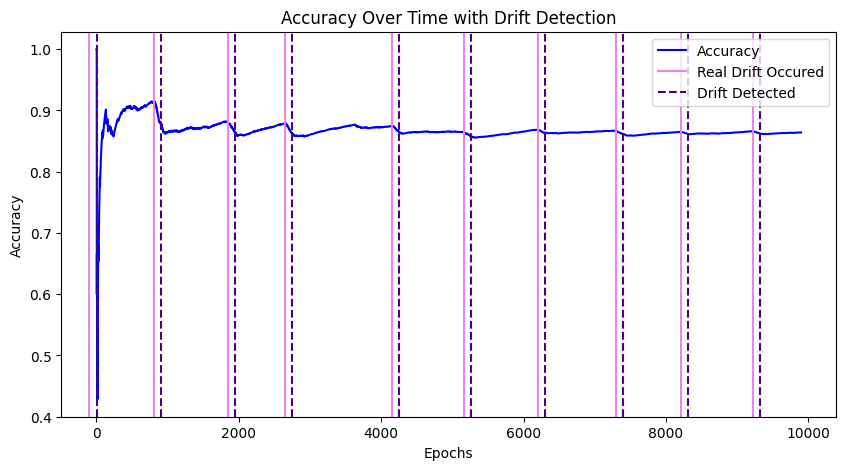

Run data exported to ./logs/kswin/160_seed/all_features_no_reset.json


In [5]:
strategy = 'all_features_no_reset'
n_history = 2000
seed = 160
feature_selector = 'boruta'
chosen_detector = 'kswin'
model_type = 'no_change' # 'hoeffding', 'no_change', 'majority'

generator = FeatureImportanceChangeGenerator(n_features=20, n_important_features=5, importance_change_interval=10, random_seed=seed)

plot_path, export_path = get_paths(chosen_detector, seed, n_history, strategy)

# main_detector = drift.ADWIN(delta=0.002)
# sensitive_detector = drift.ADWIN(delta=0.02)

main_detector = drift.KSWIN(alpha=0.005)
sensitive_detector = drift.KSWIN(alpha=0.05)

runner = DriftDetectionRunner(
    generator=generator,
    drift_detector=None,
    sensitive_drift_detector=None,
    model_type='hoeffding',
    feature_selector=None,
    plot_path=plot_path,
    export_path=export_path,
    print_plot=True
    
)
runner.run(mode='oracle_drift')

# runner = DriftDetectionRunner(generator, drift.ADWIN(), feature_selector, n_history=2000, plot_path=plot_path, export_path=export_path)
# runner.run(mode=strategy)

In [6]:
# strategies = [
#     'all_features_no_reset',
#     'all_features_with_reset',
#     'boruta_initial_only',
#     'boruta_dynamic',
#     'alpha_dynamic'
# ]



# detector = 'adwin'
# seed = 160
# window = 1000


# plot_all_strategies(detector, seed, window, strategies)